In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from lib.utils import *
import mpld3

%load_ext autoreload
%autoreload 2

In [3]:
dir = os.getcwd()
model_dir = os.path.join(dir, 'models/')
dataset_dir = os.path.join(dir, 'datasets/')
dictionary_dir = os.path.join(dir, 'dictionaries/')
executable_dir = os.path.join(dir, 'executables/')
all_words_dir = os.path.join(dir, 'allwords/')

input_file = "soya_month"
input_csv = input_file + ".csv"

In [4]:
csv = pd.read_csv(os.path.join(dataset_dir, input_csv), encoding='utf-8',parse_dates=['date'])

In [5]:
titles = csv["title"]
contents = csv["contents"]

# tags = csv["tags"]
# categories = csv["categories"]

In [6]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab=
import itertools

totalvocab_stemmed = []
totalvocab_tokenized = []
from lib.utils import *
stemmer = "lemma"
is_english_word = load_from_dictionary("english")
totalvocab_stemmed, totalvocab_tokenized = preprocess(contents, stemmer, is_english_word)

#Flatten lists
totalvocab_stemmed = list(itertools.chain.from_iterable(totalvocab_stemmed))
totalvocab_tokenized = list(itertools.chain.from_iterable(totalvocab_tokenized))

In [7]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
text = 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'
print(text)

there are 13968 items in vocab_frame


In [8]:
print (vocab_frame.head())
print
print
print
print

        words
heard   heard
today   today
set       set
events  event
lips      lip






In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words=stop_words,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(contents) #fit the vectorizer to contents

print(tfidf_matrix.shape)

CPU times: user 342 ms, sys: 41.1 ms, total: 383 ms
Wall time: 386 ms
(146, 151)


In [12]:
from collections import OrderedDict
terms = tfidf_vectorizer.get_feature_names()
# [ print(term) for term in terms[0:30] ]
idf = tfidf_vectorizer.idf_
top_idf_indices = idf.argsort()

top_idf_values = idf[top_idf_indices]
top_features = np.array(tfidf_vectorizer.get_feature_names())[top_idf_indices]
# for key,value in OrderedDict(zip(top_features, top_idf_values)).iteritems():
#     print(key)


In [13]:
remove_stems(list(OrderedDict(zip(top_features, top_idf_values)).keys() ), "soya_month_tf_idf_contents_words")

[u'start', u'starting']
[u'offer', u'offering']


In [448]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

<function print>

In [449]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 53.4 ms, sys: 2.87 ms, total: 56.2 ms
Wall time: 57.1 ms


In [450]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

# km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

print(clusters)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0]


In [451]:
articles = { 'title': titles, 'content': contents, 'cluster': clusters}
frame = pd.DataFrame(articles , columns = [ 'title', 'cluster'])

print(frame)

                                                 title  cluster
0    This could be the best postpaid plan in town —...        0
1    iPhone SE and iPad Pro 9.7 official Malaysian ...        0
2    Your WhatsApp conversations are now encrypted ...        0
3    TM UniFi Advance subscription now starts from ...        0
4      11street is offering the iPhone SE from RM1,899        0
5       Xiaomi’s new Mi Pad is more than meets the eye        0
6    Xiaomi Redmi Note 3 review: Best smartphone on...        0
7           More info on Malaysia’s newest 4G operator        0
8    Vivo’s V3Max is a metal-bodied smartphone that...        0
9               Huawei Mate 8 review: Bigger is better        0
10   The iPhone SE has the same display as the 5s a...        0
11   Enjoy iflix and Viu for free on Maxis and Hotlink        0
12   Google Cardboard Plastic: Introducing the worl...        0
13   Celcom outs Home Fibre broadband plan — 10Mbps...        0
14   Maxis responds to accusation of giv

In [452]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

0    116
1     30
Name: cluster, dtype: int64

In [453]:
# grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

# grouped.mean() #average rank (1 to 100) per cluster

In [454]:
from __future__ import print_function
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
cluster_names = {}
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
#     print(vocab_frame.ix[ [term.split(' ') for term in terms] ].values.tolist()[0][0].encode('utf-8', 'ignore'))
    cluster_names[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        cluster_name = vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')
        cluster_names[i].append(cluster_name)
        print(' %s staph' % cluster_name, end=',')
    cluster_names[i] = ' , '.join(cluster_names[i])
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='\n')
    for title in frame.loc[frame['cluster'] == i]['title'].values.tolist():
        print(' %s,' % title, end='\n')
    print() #add whitespace
    print() #add whitespace

print(cluster_names)
print()
print()

Top terms per cluster:

Cluster 0 words: galaxy staph,

Cluster 0 titles:
 This could be the best postpaid plan in town — RM80/month for unlimited everything,
 iPhone SE and iPad Pro 9.7 official Malaysian pricing revealed,
 Your WhatsApp conversations are now encrypted end to end,
 TM UniFi Advance subscription now starts from RM199/month,
 11street is offering the iPhone SE from RM1,899,
 Xiaomi’s new Mi Pad is more than meets the eye,
 Xiaomi Redmi Note 3 review: Best smartphone on a budget?,
 More info on Malaysia’s newest 4G operator,
 Vivo’s V3Max is a metal-bodied smartphone that packs a punch,
 Huawei Mate 8 review: Bigger is better,
 The iPhone SE has the same display as the 5s according to iFixit’s teardown,
 Enjoy iflix and Viu for free on Maxis and Hotlink,
 Google Cardboard Plastic: Introducing the world’s first headset for Actual Reality,
 Celcom outs Home Fibre broadband plan — 10Mbps for RM145/month,
 Maxis responds to accusation of giving special offers to those that p

In [455]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [456]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
# cluster_names = {0: 'Device, smartphones, camera', 
#                  1: 'Price, Storage, Specs', 
#                  2: 'Plan, offering, month', 
#                  3: 'Like, looks, new', 
#                  4: 'Camera, Android, battery'}

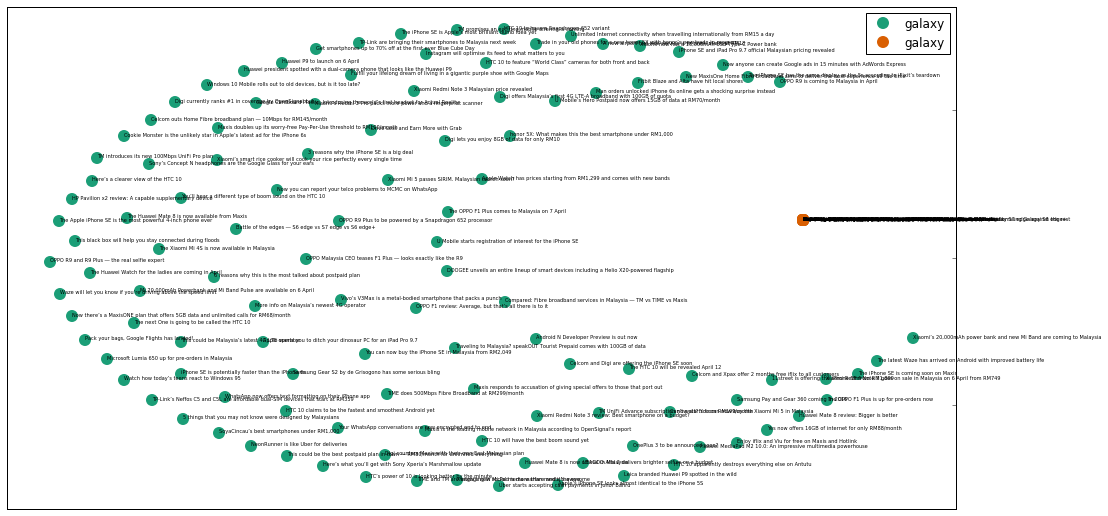

In [457]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=5)  

#uncomment the below to save the plot if need be
plt.savefig(input_file + 'clusters_small_noaxes.png', dpi=200)  
    
plt.show() #show the plot



In [458]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [459]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
# html = mpld3.fig_to_html(fig)
# print(html)

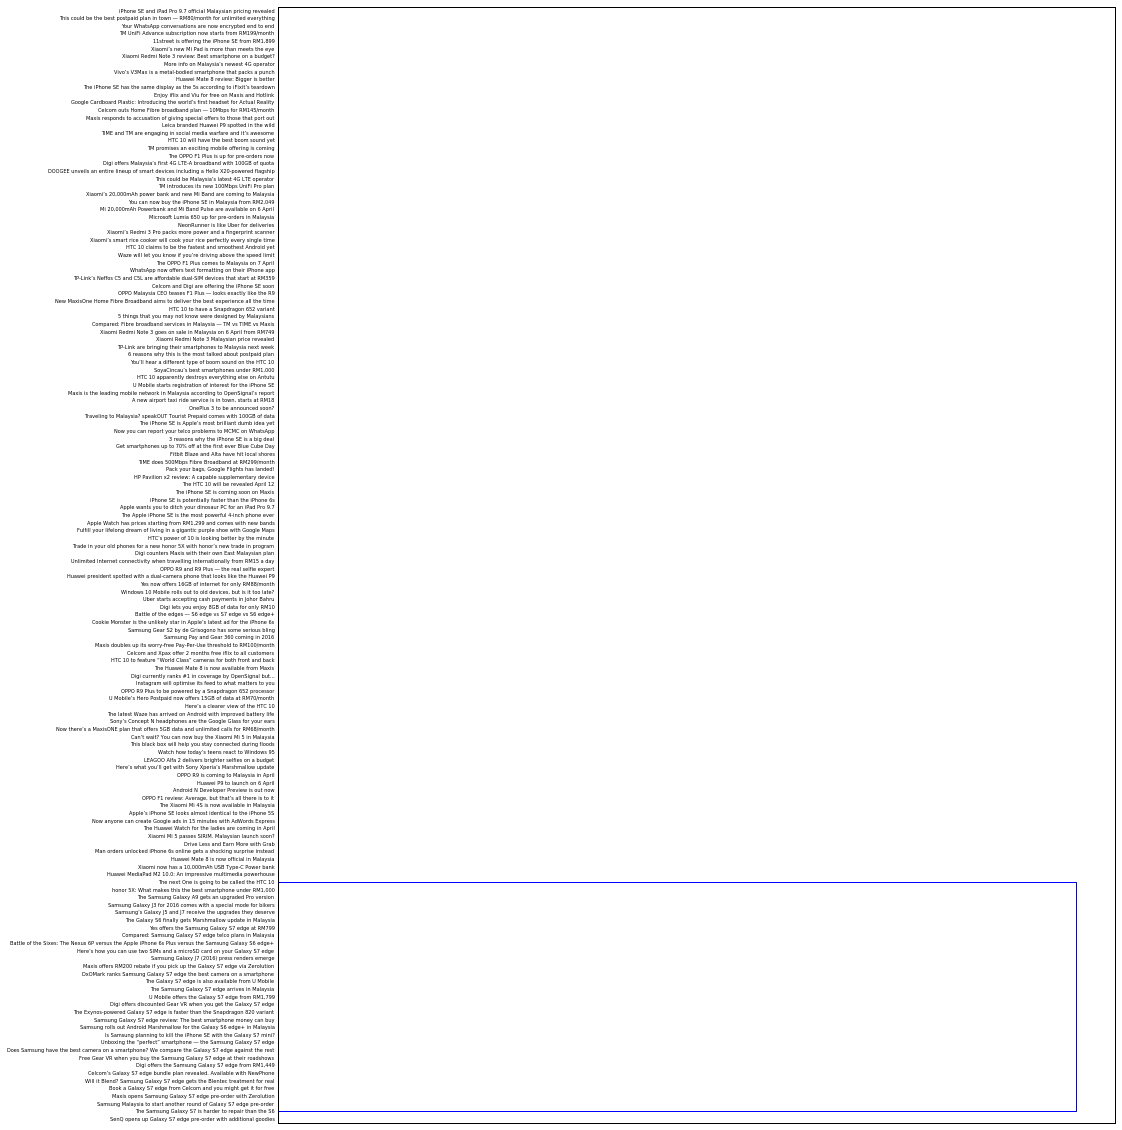

In [460]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=titles.values.tolist());

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

# plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig( input_file + 'ward_clusters.png', dpi=200) #save figure as ward_clusters